# Delay Tolerant Networks

### Description

In several instances, network communications can occur with relevant delays, as for extra-terrestial communications or for supervised monitoring networks. In such network deciding which node can communicate with which other node and when is extremely complicated issue (a np-completed scheduling problem).

### Assignments

1. Generate a series of patterns of trasmissions on a network represented as a graph. In such graph the edges are weighted accordingly to the delay between transmittion and reception.
2. Implement euristic algorithms to lower the potential of the network, i.e. aiming at minimizing the distance of the communications from their final destination.
3. Find out the most efficient algorithm

### Contacts
Leonardo Badia <badia@dei.unipd.it>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import math
import pylab as pl
from matplotlib import collections  as mc
import mpl_toolkits.mplot3d.axes3d as p3

################################################
n = 10                                         #
c = 3e8                                        #
T_tx = 10  # da regolare                       #
r_max = 60e9  # Marte                          #
tau_max = 200                                  #
################################################

In [2]:
### Generates a random network of n nodes (the first one corresponds to earth)
### r = max distance

def generate_network(n,r_max,seed=100,polar = False):
    
    np.random.seed(seed)
    
    r = np.random.rand(n,1)*r_max
    r[0] = 0 #Earth
    theta = np.random.rand(n,1)*4*np.pi - 2*np.pi
    phi = np.random.rand(n,1)*4*np.pi - 2*np.pi
    
    if polar==True:
        return np.hstack((r,theta,phi))  #polar coordinates
    
    x = r * np.cos(theta) * np.sin(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(phi)
    
    return np.hstack((x,y,z))   #cartesian coordinates

In [3]:
### Creates the weighted adjacency matrix of the network
### Entries represent propagation times between nodes

def adjacency_matrix(nodes,tau_max):
    
    n1 = nodes[:, np.newaxis, :]
    n2 = nodes[np.newaxis, :, :]
    
    A = np.linalg.norm(n1-n2, axis = 2)/c
    A[A>tau_max] = np.inf
    
    return A

In [4]:
nodes = generate_network(n,r_max)
A = adjacency_matrix(nodes,tau_max)
sorted_nodes = np.argsort(A[0,:])     #sorting based on distance from Earth

if(False):   #TEST
    print(nodes.shape)
    print(A.shape)
    print("sorted_nodes: {}".format(sorted_nodes))

In [5]:
def plot_network(nodes):
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(nodes[1:,0],nodes[1:,1],nodes[1:,2])
    ax.scatter(nodes[0,0],nodes[0,1],nodes[0,2],color="red",s=100)   #Earth
    plt.show()

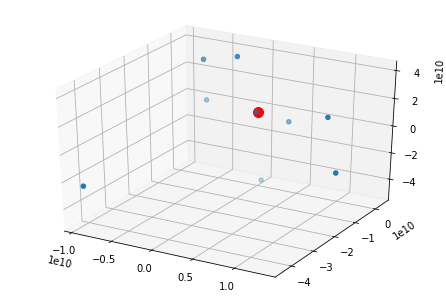

In [6]:
plot_network(nodes)

In [7]:
## disable some links for a certain amount of time
##
## delta_t = time between steps (in seconds)
##
## modes:
## light mode: few links, short time
## heavy mode: few links, long time
## unstable mode: many links, short time
## extreme mode: many links, long time
##
## priority: random, near, far
## prioritize disabling of links involving nodes near or far from Earth
## 
## custom_n_targets = number of targets
## custom_offtimes: array containing possible values for off times (in seconds)

def disable_links(A,total_time,delta_t,mode="light",priority="random", custom_n_targets = None, custom_offtimes = None):

    n = A.shape[0]
    n_updates = int(np.ceil(total_time/delta_t))
    time_max = np.max(A[0,:][np.isfinite(A[0,:])])    #propagation time from the furthest node to Earth, used as a reference
    
    At = np.repeat(A[:, :, np.newaxis], n_updates, axis=2) #add temporal dimension

    sorted_nodes = np.argsort(A[0,:])
    t_nodes = np.arange(n)
    
    if priority == "random":
        np.random.shuffle(t_nodes)   #nodes targeted for link removal
    elif priority == "near":
        t_nodes = sorted_nodes[:int(np.ceil(n/3))]
    elif priority == "far":
        t_nodes = np.flip(sorted_nodes)[:int(np.ceil(n/3))]
    
    possible_links = []
    possible_links = np.array([[x,y] for x in t_nodes for y in range(n) if x!=y if A[x,y]!=np.inf if [y,x] not in possible_links])

    if mode == "light":  
        rate = possible_links.shape[0] * 0.05  #disable 5% of possible links every time_max 
        offtimes = [time_max * 0.5]   #selected links stay off for around 0.5 * time_max
            
    elif mode == "heavy":
        rate = possible_links.shape[0] * 0.05  #disable 5% of possible links every time_max 
        offtimes = [time_max * 2]   #selected links stay off for around 2 * time_max
        
    elif mode == "unstable":
        rate = possible_links.shape[0] * 0.2  #disable 20% of possible links every time_max 
        offtimes = [time_max * 0.25]   #selected links stay off for around 0.25 * time_max
        
    elif mode == "extreme":
        rate = possible_links.shape[0] * 0.2  #disable 20% of possible links every time_max 
        offtimes = [time_max * 2]   #selected links stay off for around 2 * of time_max
    
    else:   #use light mode in case of a wrong "mode" value
        print("Wrong value for \"mode\", light mode will be used")
        rate = possible_links.shape[0] * 0.05  #disable 5% of possible links every time_max 
        offtimes = [time_max * 0.5]   #selected links stay off for around 0.5 * time_max
        
    n_targets = int(np.ceil(rate * total_time/time_max))
    
    if custom_n_targets != None:
        n_targets = custom_n
    if custom_offtimes != None:
        offtimes = custom_offtimes
 
    indexes = np.random.choice(possible_links.shape[0], n_targets)
    disabled_links = possible_links[indexes,:]
    
    for link in disabled_links:
        start = np.random.randint(0,n_updates)
        end = start + int(np.ceil(np.random.choice(offtimes) * total_time / n_updates))  #offtime expressed in number of updates
        
        if(False):   # TEST
            print(link)
            print("start {}".format(start))
            print("end {}".format(end))
        At[link[0],link[1],start:min(end, n_updates)] = At[link[1],link[0],start:min(end, n_updates)] = np.inf 
            
    return At

In [8]:
### TEST disable links
### sorted nodes = [0 4 5 8 1 2 9 3 6 7]

if(False):   #TEST
    At = disable_links(A,100,1,mode="unstable")

    for i in range(20):
        B = np.copy(At[:,:,i*5])
        B[B>tau_max] = 0
        plt.spy(B)
        plt.show()

# Greedy Routing

In every network where data is generated from a node and needs to be delivered to a different one, may it be the postal network or the internet, it is necessary to find out the route that the data should follow in order to reach its destination.

This is usually done by a routing algorithm, in the internet the most widely used ones are the Dijikstra and the Bellman-Ford algorithm, these two are used in order to find the shortest way from the source to the destination according to some metric that could be the number of hops, the end to end delay etc.
<!-- The code below is html and I used it because it gives much more freedom for
controlling images-->
<figure>
    <img src="figures/routing.svg" width=500/>
    <div style="text-align: center;"> 
        <i>
            Path obtained by applying routing between the two nodes
        </i>
    </div>
</figure>
Classical routing algorithms do not work on DTNs (Delay Tolerant Networks) because they were thought for systems where links are supposed to fail very rarely and where the end to end delay is relatively small.

In the internet the chance of a link failing is low and even if it does the end to end delay is small, so in case a packet is lost because of link failure sending the packet again is not too expensive.
In DTNs this is not true because:

* The propagation time is very high, expecially if we are conisdering satellite communication

* The chanche of link failure is very high.

On top of that it is not even possible to find the best routing algorithm for networks in general because if the traffic generated by other nodes is considered the problem becomes NP.
By analyzing the state of the art in DTN it is possible to see that the best results were mostly obtained by using greedy algorithms, i. e. algorithms that make a decision by choosing the best choice at the moment without considering long term planning.

In order to perform routing, during the first part of the project, full knowledge of the network topology and also its evolution is taken as a given, this is not a very strict requirement as this might happen in real life. For example for satellite networks, where usually link failure is caused by the interference of a celestial body, the requirement can be easily satisfied.

The algorithm implemented with this work chooses the best next hop for the packet by using a slightly modified version of the dijkstra algorithm that computes the best path from the source to the destination at a specific point in time.

It is also necessary to take collisions into account, so if sending one packet causes one the sender needs to wait until it is sure that no collision will occur, after waiting the optimal path needs to be recomputed because due to topology changes it might not be optimal anymore.

## Modified Dijkstra

The Dijkstra algorithm cam be used to find the best path between two nodes in a weighted graph with positive weights.

<figure>
    <img src="figures/dijkstra.gif" width=300/>
    <div style="text-align: center;"> 
        <i>
            Dijkstra algorithm in action
        </i>
    </div>
</figure>

Usually the algorithm is run on graphs that have constant topology but in this case the topology changes a lot so a link that was active when the packet was sent might not be active when the packet reaches its destination.

A nice implementation of the Dijkstra algorithm for DTNs was proposed in [1], in there the weigth of a node is considered equal to the time it would take the packet to reach the next hop considering that the link might fail.

The pseudo code for the algorithm is:
```
Input = G=(E, V), s, T, w(e,t)
Q = V
L[s]=0
L[v]=inf for every v != s
while Q != {} do
    u = u in Q that minimizes L[u]
    Q = Q - u
    for each edge e in E between u and another vertex v do
        if L[v] > L[u] + w(e, T + L[u]) then
            L[v] = L[u] + w(e, T + L[u])
        end if
    end for
end while
```
Where G is the graph representing the network, s is the starting node, T is the starting time, w(e,t) is the weight of edge e at time t.
The only difference from the standard algorithm is that in the standard case w(e,t) is constant in t.


In [9]:
#used to check if the time exceeds the maximum time of the system
def check_time_step(A, time):
    
    max_time_step = A.shape[2]
    
    if time >= max_time_step:
        raise Exception("Maximum time limit exceded")

# used to check if the link becomes unavailable before the packet is fully transmitted
#weigths = time series of the weight of the considered link
#start = starting time
#end = ending time
def check_interval(weights, start, end):
    return np.sum(weights[int(start):int(end)] == np.inf) == 0 

#finds the next useful interval to send the packet if the link is down
#current_time = earlyest time when the packet can be sent
#delta_time = time interval 
#e2e = end to end delay
#distances = weights of the edge during time
def find_next_interval(current_time, delta_time, e2e, distances):
    
    current_delta = math.floor(current_time / delta_time)
    #the last timeslot has to be considered as well so ceil is needed
    ending_delta = math.ceil((current_time+e2e) / delta_time)
    
    #if we already have a good interval then the packet can be sent immediatly
    if check_interval(distances, current_delta, ending_delta):
        return current_time
    #otherwise iterate until a good interval is found
    else:
        #time of the first np.inf after current_time
        i = current_delta + np.argmin(distances[current_delta:ending_delta] != np.inf)
        
        #number of timesteps required to send a packet
        delta_e2e = np.ceil(e2e / delta_time)
        
        #keep increasing i while either the max length is reached or a good interval is found
        while i + delta_e2e < distances.shape[0] and not check_interval(distances, i, i + delta_e2e):
            i += 1
        
        return i * delta_time

#used to find the next node and the arrival times
def find_next(starting_node, previous, times, earth=0):
    
    result = earth
    current = earth
    
    while current != starting_node:
        result = current
        current = int(previous[current])
        
    return result, times[result]
       
#performs a modified version of the dijkstra algorithm that adapts to this specific problem
#A = adjacency matrix
#starting_node = node sending the packet
#ttr = transmission time
#delta_time = timestep dimension
#earth = earth node
def DTN_dijkstra(A, starting_node, starting_time, ttr, delta_time, earth = 0):
    
    N = A.shape[0]
    
    #setting the arrival time of the packet to each node to infinity
    distances = np.ones(N) * np.inf
    distances[starting_node] = starting_time
    
    current = starting_node
    visited_nodes = 0
    
    #previous step in the shortest path
    previous = np.ones(N)*(-1)
    previous[starting_node] = starting_node
    
    #if the source is the destination do nothing
    if current == earth:
        return starting_time, -1
    
    #keep going until the shortest path to earth is found
    while current != earth:
        
        #arrival time of the packet in the current node
        current_time = distances[current]
        #time slot of the packet arrival
        current_step = math.floor(current_time / delta_time)
        
        #checking if the packet arrives after the maximum time
        check_time_step(A, current_step)
        
        #arrival times to each node if the message started from current node
        new_dists = np.zeros(N)
        
        #compute the arrival time to each node
        for i in range(N):
            
            #computing e2e delay as tp + ttr
            tp = np.min(A[current, i, :])
            
            if tp == np.inf:
                new_dists[i] = np.inf
            else:
                e2e = np.min(A[current, i, :]) + ttr
            
                #finding out when the packet can leave the current node to reach the next one
                next_good = find_next_interval(current_time, delta_time, e2e, A[current, i, :])
            
                #finding out the arrival time of the packet to node i after passing from current
                new_dists[i] = next_good + e2e
        
        new_dists[current] = current_time
        
        #if the arrival time is improved then the previous node is changed
        previous[distances > new_dists] = current
        
        #setting the correct arrival time to each node
        distances = np.minimum(distances, new_dists)
        
        visited_nodes += 1
        sorting_indexes = np.argsort(distances)
        
        current = sorting_indexes[visited_nodes]
    
    return find_next(starting_node, previous, distances, earth)

In [10]:
class Packet():
    
    def __init__(self, index ,destination):
        
        #final destination of the packet
        self.destination = destination
        
        #arrival time at the next hop
        self.arrival_time = -1
        
        #index of the next hop
        self.next_hop = -1
        
        #index that identifies the packet, used for debugging purposes
        self.id = index
        
        self.route = []
        
        self.arrival_times = []
    
    #function that is called when str(packet) is called
    def __str__(self):
        return f"id: {self.id}, next hop: {self.next_hop}, destination: {self.destination}"

class Node():
    
    def __init__(self, packets, index):
        
        #queue of the packets
        self.packets = packets
        
        #index of the node
        self.id = index
    
#returns the queues of packets at each node
def get_nodes(N, packets):
    
    #generate N empty queues
    queues = [[] for i in range(N)]
    
    #add every packet to the queue corresponding to its starting node
    for i in range(packets.shape[0]):
        queues[packets[i,0]].append(Packet(i, packets[i,1]))
    
    #generating the Node objects
    nodes = []
    for i in range(N):
        nodes.append(Node(queues[i], i))
    
    return nodes 

#function used to sort the nodes based on the one that has the packet that
#would arrive first to the next point
def sorting_function(node):
    
    #if no packet is queued then the node has to be placed at the end of the sorted array
    if len(node.packets) == 0:
        return np.inf
    else:
        return node.packets[0].arrival_time

#runs djikstra on each node assuming that a packet is queued and that
#it is sent as soon as the sender can send it
'''
nodes = list of Node objects
first_free_moment = array indicating the first available moment for a node to send/recieve 
a packet
'''
def dijkstra_on_nodes(A, nodes, first_free_moment, ttr, delta_time):
    
    #for each node
    for i in range(len(nodes)):
        
        #if the node is not empty
        if len(nodes[i].packets) > 0:
            
            #compute dijkstra on the first node of the queue
            next_hop, arrival_time = DTN_dijkstra(
                A, 
                i, 
                first_free_moment[i], 
                ttr, 
                delta_time, 
                earth = nodes[i].packets[0].destination
            )
            
            #update the information of the packet based on dijikstra result
            nodes[i].packets[0].next_hop = int(next_hop)
            nodes[i].packets[0].arrival_time = arrival_time

    return nodes

#checks if there is one node that is completely isolated from the rest
#note that this does not notify the case where two nodes are connected
#but are separated from the rest
def check_nodes_connectivity(A):
    
    #matrix saying if an edge is up or not
    connectivity = np.min(A, axis = 2)
    
    #setting the diagonal to inf so later i can check if a whole column is equal to inf
    connectivity[connectivity == 0] = np.inf
    
    #if there is a column that contains only inf it means that the node is disconnected
    if np.max(np.min(connectivity, axis = 1)) == np.inf:
        raise Exception("At least one of the nodes is never connected to the graph")
    
#packets = source and destination of every packet
def greedy_routing(A, packets, ttr, delta_time):
    
    check_nodes_connectivity(A)
    N = A.shape[0]
    nodes = get_nodes(N, packets)
    #at the beginning all of the nodes can transmit a packet theoretically
    first_free_moment = np.zeros(N)
    
    #number of packets that reached their destination
    arrived_packets = 0
    final_packets = []
    
    #while some packets aren't arrived yet
    while arrived_packets != packets.shape[0]:
        
        #find out the next step and the arrival time of all the first packets in the queues
        nodes = dijkstra_on_nodes(A, nodes, first_free_moment, ttr, delta_time)
        #sort the nodes from the one that has the packet that would reach first the next hop
        nodes.sort(key = sorting_function)
        #packet to be eventually sent
        pts = nodes[0].packets[0]
        #boolean value that tells if the packet was sent or not
        sent = False
        
        #propagation time from current node to next hop
        tp = np.min(A[pts.next_hop, nodes[0].id])        
        
        #if the first bit of the packet reaches the receiver when the receiever is free
        if first_free_moment[pts.next_hop] <= pts.arrival_time - ttr:
            
            #set the receiver as busy until the packet is fully arrived
            first_free_moment[pts.next_hop] = pts.arrival_time
            #set the sender as busy until the packet is fully sent
            first_free_moment[nodes[0].id] = pts.arrival_time - tp            
            sent = True
            #send the packet by removing it from the sender queue
            nodes[0].packets.pop(0)

        else:
            #if the reciever is not free set the sender as busy until it is sure that 
            #when he sends the reciever will be idle
            first_free_moment[nodes[0].id] = first_free_moment[pts.next_hop] - tp + 1e-7
        
        #sort the nodes back by id in order to add the packet to the receiver queue
        nodes.sort(key = lambda node: node.id)
        
        #if a packet was sent
        if sent:
            
            pts.route.append(pts.next_hop)
            pts.arrival_times.append(pts.arrival_time)
            
            #if the packet reached its destination then remove it from the system
            if pts.next_hop == pts.destination:
                arrived_packets += 1
                final_packets.append(pts)
            
            #else append it to the queue of the receiver
            else:
                nodes[pts.next_hop].packets.append(pts)
                
        
    return final_packets

In [11]:
At = disable_links(A,3000,1,mode="unstable")

In [12]:
#print(At[:,:,7])

In [13]:
packets = np.random.randint(0, n, (30, 2))
packets[:,1] = 0
packets = packets[packets[:, 0] != 0]
print(len(packets))
#print(packets)
delta_time = 1
ttr = 50
packets = greedy_routing(At, packets, ttr, delta_time)

25


In [14]:
for packet in packets:
    print(packet.arrival_times)

[50.943771238194515]
[100.94377133819451]
[150.94377143819452]
[200.94377143819452]
[250.94377143819452]
[300.9437714381945]
[350.9437714381945]
[400.9437714381945]
[450.9437715381945]
[500.9437716381945]
[550.9437717381945]
[600.9437717381945]
[226.62994748157166, 650.9437717381945]
[184.68740028242507, 700.9437718381945]
[234.68740028242507, 750.9437718381945]
[284.68740038242504, 800.9437718381945]
[937.3413179369905]
[124.3187435097143, 987.3413179369905]
[174.3187435097143, 1037.3413179369907]
[334.687400482425, 873.549309323458, 1087.3413180369905]
[384.68740058242497, 1137.975038778476]
[434.68740058242497, 1245.9437712381946]
[484.687400682425, 1295.9437712381946]
[534.687400682425, 1345.9437712381946]
[323.6024537012039, 1087.0312675402813, 1395.9437712381946]


In [15]:
###DELAY FUNCTION###

#This function takes in input 3 parameters: 
# 1) scheduling is defined as a list of lists in the sense that it is a list that contains the scheduling of 
#every node which corresponds to the istants of time a node has to forward packets that are in its queue. For 
#every node these "forwarding istants" are compactly put in a list.
# 2) routing is a slightly more complicated data structure; Here for every node we place a list whose elements 
#are the lists containg the hops that every packet in the queue of a specific node has to go through in order to 
#reach its destination
# 3) n_pkts is the total number of packets that has to be forwarded in our network

def delay(scheduling,routing,n_pkts):

    #The waiting list is obtained as a result of the concatenation of all the lists present in scheduling
    waiting = [wait for node in scheduling for wait in node] 
    #The routes list instead of having all the forwarding times, it contains all the hops every pkt has to do
    routes = [path for node in routing for path in node]
    
    longest = 0
    
    for i in range(n_pkts):
        path = routes[i]
        #Here with tleft we are not taking into account the fact that a packet may be queued in some intermediate 
        #nodes on its remaining way to destination. Anyway this does not represent a problem given the fact that 
        #our scheduling provides us not just with the information about when a packet is sent from its 
        #source node but also all the instants it will be forwarded by intermediate nodes.
        #As we see tleft is made of the sum of transmission and propagation time for every remaining hop
        tleft = sum([T_tx + A[path[j],path[j+1]] for j in range(len(path)-1)]) 
          
            
        #The total time is given by the sum of the time we wait before forwarding and tleft which can be seen as
        #the minimum time it takes to go through the rest of the path
        t_tot = waiting[i] + tleft 
        
        #Here we are looking for the last packet to arrive at destination
        longest = max(longest,t_tot)  
    return longest

In [16]:
#TEST 
#Here we test our function with 3 packets
if(False):
    n_pkts = 3
    T_tx = 0.5
    A=np.zeros((3,3))
    A[0,1] = A[1,0] = 1
    A[1,2] = A[2,1] = 2
    A[0,2] = 3

    scheduling = [[2,4],[1,5.5],[]]
    routing = [[[0,2],[0,1,2]],[[1,2]],[]]

    delay = delay(scheduling,routing,n_pkts)
    print(delay)

In [17]:
### pkt_plot function
#This function takes in input the times in which packets are recepted at destination and the transmission time
#It enables us to visualize the moments in which we receive packets
def pkt_plot(recept_times,t_tx):
    lines=[[(x,0),(x+t_tx,0)] for x in recept_times]
    lc = mc.LineCollection(lines, linewidths=10)
    fig, ax = pl.subplots()
    ax.add_collection(lc)
    
    ax.set_xlim(0,(recept_times[-1]+t_tx)*1.01)
    ax.set_ylim(-0.5,0.5)
    ax.set_yticks([])
    
    pl.show()

In [18]:
#Test of pkt_plot function
if(False):
    recept_times=[1,3,7,12,34,38,43,49,57,63,68,75,88,95,100]

    t_tx=1
    pkt_plot(recept_times,t_tx)

In [19]:
###deviations: given an optimal routing (that in our case is the one determined by Dijkstra) this function returns 
#the fraction of times a packet doesn't follow the route which was pre-established by the algorithm
def deviations(optimal,routing,n_pkts):
    dev = 0
    for node in routing:
        dev = dev + sum([1 for path in node if path != optimal[path[0]][path[-1]]])
    return dev/n_pkts

In [20]:
#TEST of deviations function
if(False):
    optimal = [[[0,0],[0,1],[0,2]],[[1,0],[1,1],[1,2]],[[2,0],[2,1],[2,2]]]  
    dev = deviations(optimal,routing,3)
    print(dev)

In [21]:
###throughput function
#the throughput enables us to evaluate the performance of our routing algorithm 
#the function returns the ratio between the number of packets sent and the total time elapsed
def throughput(n_pkts,delay):
    return n_pkts/delay

In [22]:
#TEST throughput using the delay function
if(False):
    throughput(n_pkts,delay)

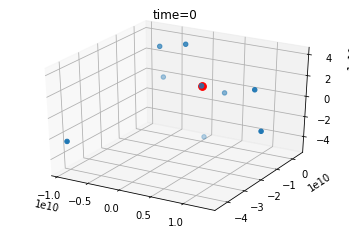

In [23]:
## ANIMATION 1

#enable first line to make the animation work
#WARNING: all other figures will be affected until you restart the kernel

#%matplotlib notebook 

coord = np.copy(nodes)
polar = generate_network(n,r_max,polar=True)

def update_graph(num):

    theta = polar[:,1]
    phi = polar[:,2]
    
    old_r = np.linalg.norm(coord,axis=1)
    
    coord[:,0] += - c*np.cos(theta)*np.sin(phi)
    coord[:,1] += - c*np.sin(theta)*np.sin(phi)
    coord[:,2] += - c*np.cos(phi)
    
    new_r = np.linalg.norm(coord,axis=1)
    
    not_done = new_r < old_r  #this happens after a packet reach Earth

    #coord = coord * not_done.reshape((n,-1))  #sets coordinates of a pkt to 0 if it already reached Earth

    for i in range(n):    # ISSUE: previous line doesn't work, this "for" cycle is a substitute
        if not not_done[i]:
            coord[i,0] = coord[i,1] = coord[i,2] = 0
            
    graph._offsets3d = (coord[:,0],coord[:,1],coord[:,2])
    title.set_text("time={}".format(num))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Pkts')

graph = ax.scatter(coord[:,0],coord[:,1],coord[:,2])
ax.scatter(0,0,0,color="red",s=60)   #Earth

ani = animation.FuncAnimation(fig, update_graph, 
                               interval=50, blit=False)

plt.show()

<IPython.core.display.Javascript object>


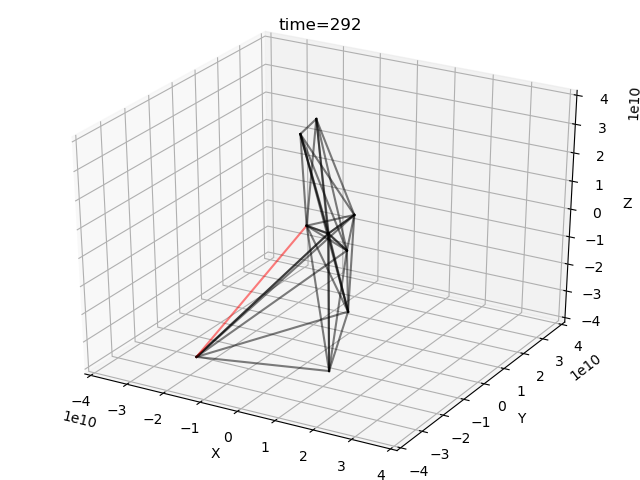

In [25]:
## ANIMATION 2

#enable first line to make the animation work
#WARNING: all other figures will be affected until you restart the kernel

%matplotlib notebook 

#returns a list of active links
def get_links(A):
    n = A.shape[0]
    return [np.array([nodes[i],nodes[j]]).T for i in range(n) for j in range(i+1) if A[i,j]!=np.inf]

#checks if a link is active 
def check_link(link, link_list):
    for x in link_list:
        if np.array_equal(x, link):
            return True
    return False

#At = disable_links(A,5000,1,mode="heavy")  #test

n_updates = At.shape[2]
links = get_links(A)
active_links = [get_links(At[:,:,t]) for t in range(n_updates)]

def update_lines(num, dataLines, lines) :

    title.set_text("time={}".format(num))
    
    for line, data in zip(lines, dataLines) :
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :])
        line.set_3d_properties(data[2, :])
        line.set_color("black")
        if not check_link(data, active_links[num]):
              line.set_color("red")
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

data = links
lines = [ax.plot(dat[0, :], dat[1, :], dat[2, :],alpha=0.5)[0] for dat in links]

if True:   #autoscale off
    # Setting the axes properties
    ax.set_xlim3d([-4e10, 4e10])
    ax.set_xlabel('X')

    ax.set_ylim3d([-4e10, 4e10])
    ax.set_ylabel('Y')

    ax.set_zlim3d([-4e10,4e10])
    ax.set_zlabel('Z')

title = ax.set_title('Links')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, n_updates, fargs=(data, lines),
                              interval=5, blit=False)

plt.show()

# Bibliography

[1] Jain, Sushant, Kevin Fall, and Rabin Patra. "Routing in a delay tolerant network." Proceedings of the 2004 conference on Applications, technologies, architectures, and protocols for computer communications. 2004.